In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt2
from keras.callbacks import Callback
from distutils.util import strtobool


In [8]:
# ## Stock data function configured to drop all columns except 'Open','High' and 'Close'


class NBatchLogger(Callback):
    def __init__(self,display=100):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.display = display

    def on_epoch_end(self,epoch,logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0:
           
            print('\r                                                                                   \rEpoch: %d/%d\tLoss: %0.4f\tAcc: %0f\tVal_loss: %0f\tVal_acc: %0f' % (epoch + 1, 
                self.params['epochs'], 
                logs.get('loss'), 
                logs.get('acc'), 
                logs.get('val_loss'), 
                logs.get('val_acc')),end='')

def bool_query(question):
    print('%s [y/n]' % question)
    while True:
        try:
            return strtobool(input().lower())
        except ValueError:
            print('Please respond with \'y\' or \'n\'.')



def get_stock_data(csv_name, normalized=0):
#     url="http://www.google.com/finance/historical?q=%s&ei=u-lHWfGPNNWIsgHHqIqICw&output=csv" % stock_name 


    #col_names = ['Date','Open','High','Low','Close','Volume']
    col_names = ['Date','Temp','Wind_Speed','Precip_Amount','Chill','Solar_Rad','Humidity','Cloud_Cover','Demand']
    
    #stocks = pd.read_csv(url, header=0, names=col_names) 
    stocks = pd.read_csv(csv_name, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    #remove date
    df.drop(df.columns[[0]], axis=1, inplace=True) 
    return df


# ## Loading GOOGL stock data from yahoo.com




# ## Updated load_data function from lstm.py, configured to accept any amount of features.
# ## It is set to calculate the last feature as a result.



def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    
    print("Data Shape: " + str(data.shape)) # A 731x8 matrix so 731 rows and 8 cols with the last col as output"
    print("Seq_len: " + str(seq_len))

    #print("Orig_rows:")
    #print(data[:15,:])

    # what the seq_len does is it groups data in a seq i.e if seq = 5 then each row will now be a 2D matrix so we actually have 3D overall
    # each 2D matx will consist of 5 rows with values in the next 2D matx being upshifted by 1 so

    # Row 1 ->
    # [[a_11,..]
    #  [a_21,..]
    #   .
    #   .
    #  [a_51,..]]
    #
    # Row 2 ->
    # [[a_21,..]
    #   .
    #   .
    #  [a_61,..]]
    # and so on

    sequence_length = seq_len #+ 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)

    #print("\nResult_rows:")
    #print(result[:6,:,:])

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    
    x_train = train[:,::-1, :-1] # train[:, :-1]
    y_train = train[:,-1,-1]
    x_test = result[int(row):,::-1, :-1]   # all rows, all 5 data points which is at t, t-1, t-2,...,t-4 (because reverse read), no include last col!
    y_test = result[int(row):-20, -1, -1]   #result[int(row):-10, 0, -1] # do not include last 10 rows as thats true_test, orig: y_test = result[int(row):, -1][:,-1]

    #print("\nY_TRAIN_rows===>")
    #print(y_train[:6])

    #print("\nX_TRAIN_rows===>")
    #print(x_train[:6,:,:])

    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  # X_test

    return [x_train, y_train, x_test, y_test]


# ## Building model functions




def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="RMSprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model




# ## Setting X and Y for training and testing

Data Shape: (751, 8)
Seq_len: 3
X_train (673, 3, 7)
y_train (673,)
X_test (75, 3, 7)
y_test (55,)


/home/nbuser/anaconda3_410/lib/python3.5/site-packages/ipykernel/__main__.py:126: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/ipykernel/__main__.py:126: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=3, input_shape=(None, 7))`
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/ipykernel/__main__.py:135: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Compilation Time :  0.021329402923583984
Epoch: 2000/2000	Loss: 0.0137	Acc: 0.002123	Val_loss: 0.006215	Val_acc: 0.000000   

Train Score: 0.00 MSE (0.07 RMSE)
Test Score: 0.00 MSE (0.03 RMSE)
(75, 1)
Mean Square Error: 1583.43753435


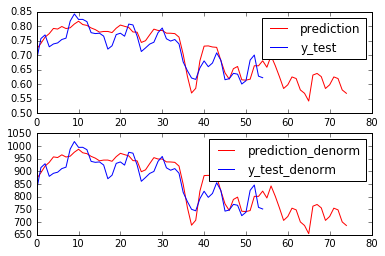

In [9]:

def main():

    csv_name = 'data/round1_raw4.csv'
    df = get_stock_data(csv_name,0)
    df.tail()


    # ## Saving the data to a file for a future use



    #today = datetime.date.today()
    #file_name = stock_name+'_stock_%s.csv' % today
    #df.to_csv(file_name)
    max_y_val = np.max(df['Demand'])


    # normalise data this is important!
    df['Temp'] = df['Temp'] / np.max(df['Temp'])
    df['Wind_Speed'] = df['Wind_Speed'] / np.max(df['Wind_Speed'])
    df['Precip_Amount'] = df['Precip_Amount'] / np.max(df['Precip_Amount'])
    df['Chill'] = df['Chill'] / np.max(df['Chill'])
    df['Solar_Rad'] = df['Solar_Rad'] / np.max(df['Solar_Rad'])
    df['Humidity'] = df['Humidity'] / np.max(df['Humidity'])
    df['Cloud_Cover'] = df['Cloud_Cover'] / np.max(df['Cloud_Cover'])
    df['Demand'] = df['Demand'] / np.max(df['Demand'])
    df.head(5)


    ## load data into matrices
    window = 3
    X_train, y_train, X_test, y_test = load_data(df[::1], window) # The -1 in the end makes it read backwards so test day must be added to top!!
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    
    #print("x_train->")
    #print(X_train[:4,:,:])

    # ## Loading the model sequence structure

    model = build_model([7,window,1])
    #model = build_model2([3,window,1])

    out_batch = NBatchLogger(display=10)

    #stop training if user cancels
    #if(not bool_query("Do wish to start training?")):
        #return


    model.fit(
        X_train,
        y_train,
        batch_size=512,
        epochs=2000, #~1500 is ok
        validation_split=0.3, #originally 0.1 # increasing this helps
        verbose=0,
        callbacks=[out_batch])

    print("\n")


    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test[:y_test.shape[0]], y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))



    # print(X_test[-1])
    diff=[]
    ratio=[]
    p = model.predict(X_test)
    print(p.shape)

    #upgrade by mean square error
    #p=p+math.sqrt(testScore[0])
    #for u in range(len(y_test)):
        #pr = p[u][0]
        #ratio.append((y_test[u]/pr)-1)
        #diff.append(abs(y_test[u]- pr))
        #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))


    # ## Predictions vs Real results

    p_denorm = p*max_y_val
    y_test_denorm = y_test*max_y_val

    mse = mean_squared_error(p_denorm[:-20],y_test_denorm)
    print("Mean Square Error: " + str(mse))

    plt2.figure(1)
    plt2.subplot(211)
    plt2.plot(p,color='red', label='prediction')
    plt2.plot(y_test,color='blue', label='y_test')
    plt2.legend(loc='upper right')

    plt2.subplot(212)
    plt2.plot(p_denorm,color='red', label='prediction_denorm')
    plt2.plot(y_test_denorm,color='blue', label='y_test_denorm')
    plt2.legend(loc='upper right')
    plt2.show()


main()